In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import os
from matplotlib.patches import Patch
from wordcloud import WordCloud


In [100]:
# Read in the two scored‐prompt CSVs
df1 = pd.read_csv(
    '/Users/clairejin/Classes/15784/s25-coopai/data/rts_matrix_0/0501_rts_oai_sim-prompts-scored.csv',
    sep='|'
)
df2 = pd.read_csv(
    '/Users/clairejin/Classes/15784/s25-coopai/data/rts_matrix_0/0502_rts_deepseek_sim-prompts-scored.csv',
    sep='|'
)

# Concatenate them into one DataFrame
df = pd.concat([df1, df2], ignore_index=True)

# Show the first few rows
df.head()

,timestamp,round_index,p1_choice,p1_move,p2_choice,p1_payoff,p2_payoff,p1_gain_from_simulating,p1_simulation_error,p2_simulation_prompt,...,arg_verbose,prompt_eval_payoff_error,prompt_eval_p1_payoff_inclusion,prompt_eval_simulation_signal,prompt_eval_simulation_cost,prompt_eval_rule_error,prompt_eval_extra_score,prompt_eval_consistency_score,prompt_eval_comments,prompt_eval_ts
0,2025-05-01 21:56:39,0,simulate,trust,cooperate,3.0,3.0,0.5,0.0,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-05-01 21:56:39,1,simulate,trust,cooperate,3.0,3.0,0.5,0.0,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-05-01 21:56:39,2,simulate,trust,cooperate,3.0,3.0,0.5,0.0,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-05-01 21:56:39,3,simulate,trust,cooperate,3.0,3.0,0.5,0.0,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-05-01 21:56:39,4,simulate,trust,cooperate,3.0,3.0,0.5,0.0,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
df.columns

Index(['timestamp', 'round_index', 'p1_choice', 'p1_move', 'p2_choice',
       'p1_payoff', 'p2_payoff', 'p1_gain_from_simulating',
       'p1_simulation_error', 'p2_simulation_prompt', 'p1_rationale',
       'p2_rationale', 'p1_prob_trust', 'p1_prob_partial_trust',
       'p1_prob_walk_out', 'p1_prob_simulate', 'p2_prob_cooperate',
       'p2_prob_defect', 'p2_simulated_prob_cooperate',
       'p2_simulated_prob_defect', 'stackelberg_p1_prob_trust',
       'stackelberg_p1_prob_partial_trust', 'stackelberg_p1_prob_walk_out',
       'stackelberg_p2_prob_cooperate', 'stackelberg_p2_prob_defect',
       'stackelberg_p1_payoff', 'stackelberg_p2_payoff', 'arg_p1_model',
       'arg_p2_model', 'arg_temperature', 'arg_payoff_matrix_path',
       'arg_rounds', 'arg_simulation_cost', 'arg_simulation_type',
       'arg_matrix_number', 'arg_csv_output', 'arg_verbose',
       'prompt_eval_payoff_error', 'prompt_eval_p1_payoff_inclusion',
       'prompt_eval_simulation_signal', 'prompt_eval_simulat

In [102]:
for col in ['arg_p1_model', 'arg_p2_model']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace('lambda-', '', regex=False)

In [182]:
df['p1_simulate'] = df['p1_choice'].apply(lambda x: 1 if x == 'simulate' else 0)

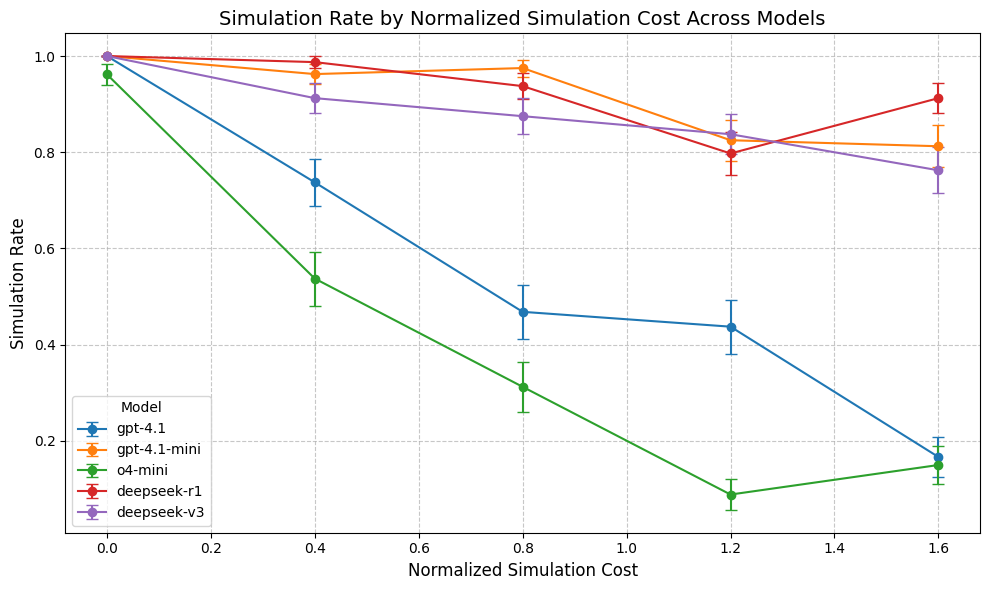

In [104]:
plt.figure(figsize=(10, 6))

# Get unique models
models = df['arg_p1_model'].unique()

# Create a line for each model
for model in models:
    # Filter data for this model
    model_data = df[df['arg_p1_model'] == model]
    
    # Group by simulation_cost and calculate mean and standard error of p1_simulate
    grouped_stats = model_data.groupby('arg_simulation_cost')['p1_simulate'].agg(['mean', 'std', 'count']).reset_index()
    
    # Calculate standard error
    grouped_stats['se'] = grouped_stats['std'] / np.sqrt(grouped_stats['count'])
    
    # Sort by simulation_cost to ensure line is drawn correctly
    grouped_stats = grouped_stats.sort_values('arg_simulation_cost')
    
    # Plot this model's line with error bars
    plt.errorbar(
        grouped_stats['arg_simulation_cost'], 
        grouped_stats['mean'], 
        yerr=grouped_stats['se'],  # Using standard error for error bars
        marker='o', 
        linestyle='-', 
        label=model,
        capsize=4  # Adds caps to the error bars
    )

# Add labels and legend
plt.xlabel('Normalized Simulation Cost', fontsize=12)
plt.ylabel('Simulation Rate', fontsize=12)
plt.title('Simulation Rate by Normalized Simulation Cost Across Models', fontsize=14)
plt.legend(title='Model', loc='best')
plt.grid(True, linestyle='--', alpha=0.7)

# Improve appearance
plt.tight_layout()
plt.savefig('figures/simulation_rate_by_normalized_simulation_cost_across_models.png')

In [105]:
# get average simulation error by model and simulation type
df.groupby(['arg_p1_model', 'arg_simulation_type'])['p1_simulation_error'].mean()

arg_p1_model  arg_simulation_type       
deepseek-r1   simulate_and_best_response    0.000000
              simulate_externally           0.110705
              simulate_internally           0.242088
              simulate_via_prompting        0.250215
deepseek-v3   simulate_and_best_response    0.000000
              simulate_externally           0.148864
              simulate_internally           0.240909
              simulate_via_prompting        0.270690
gpt-4.1       simulate_and_best_response    0.000000
              simulate_externally           0.290179
              simulate_internally           0.726786
              simulate_via_prompting        0.518617
gpt-4.1-mini  simulate_and_best_response    0.000000
              simulate_externally           0.214674
              simulate_internally           0.201099
              simulate_via_prompting        0.258427
o4-mini       simulate_and_best_response    0.000000
              simulate_externally           0.371463
     

In [106]:
# count nan in f['p1_simulation_error']
df_dropna = df.dropna(subset=['p1_simulation_error'])

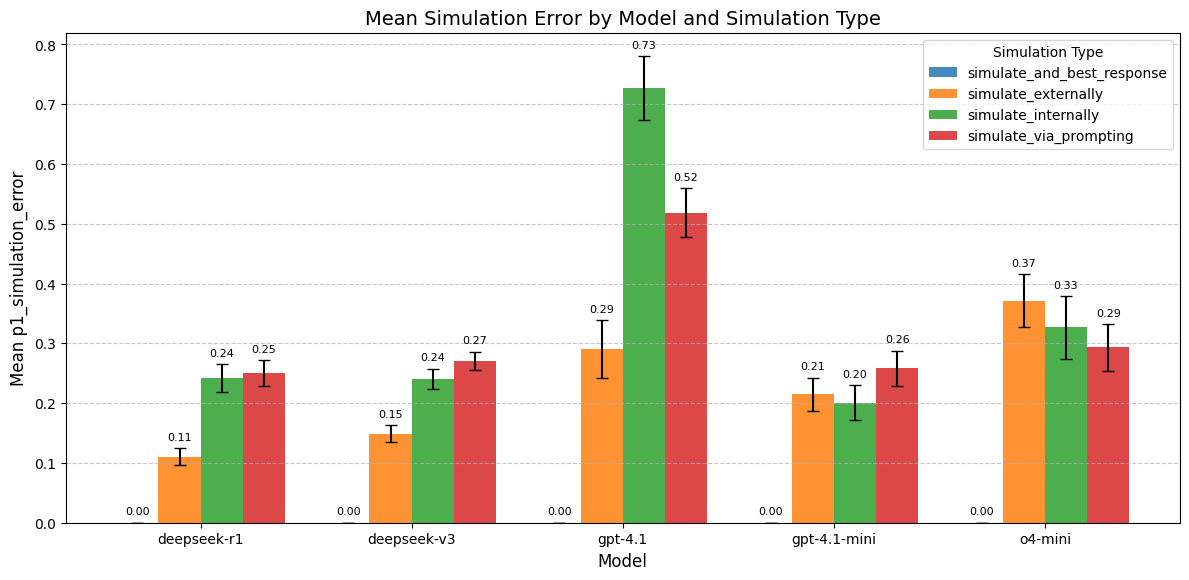

In [137]:
grouped = df_dropna.groupby(['arg_p1_model', 'arg_simulation_type'])['p1_simulation_error']
means = grouped.mean().unstack()
# Calculate standard error (std/sqrt(n))
errors = grouped.apply(lambda x: stats.sem(x)).unstack()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 7))

# Set the width of the bars
bar_width = 0.8 / len(means.columns)
positions = np.arange(len(means.index))

# Plot each simulation type as a group of bars
for i, sim_type in enumerate(means.columns):
    # Calculate position for this group
    pos = positions + i * bar_width - (len(means.columns) - 1) * bar_width / 2
    
    # Plot bars with error bars
    bars = ax.bar(
        pos, 
        means[sim_type], 
        width=bar_width, 
        label=sim_type, 
        yerr=errors[sim_type], 
        capsize=4,  # Add caps to error bars
        alpha=0.85  # Slight transparency for better visibility
    )
    
    # Annotate each bar with its value
    for j, bar in enumerate(bars):
        height = bar.get_height()
        value = means[sim_type].iloc[j]
        # Format the value to 2 decimal places
        formatted_value = f'{value:.2f}'
        
        # Position the text above the bar
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            height + errors[sim_type].iloc[j] + 0.01,  # Position text slightly above error bar
            formatted_value,
            ha='center',            # Horizontal alignment
            va='bottom',            # Vertical alignment
            fontsize=8,             # Smaller font to avoid overlap
            rotation=0,            # Rotate text to avoid overlap
        )

# Customize the plot
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Mean p1_simulation_error', fontsize=12)
ax.set_title('Mean Simulation Error by Model and Simulation Type', fontsize=14)
ax.set_xticks(positions)
ax.set_xticklabels(means.index, rotation=0, ha='center')
ax.legend(title='Simulation Type')
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add some space at bottom for rotated labels and at top for the annotations
plt.tight_layout()
plt.subplots_adjust(bottom=0.2, top=0.9)

# Show the plot
plt.savefig('figures/simulation_error_by_model_and_simulation_type.png')

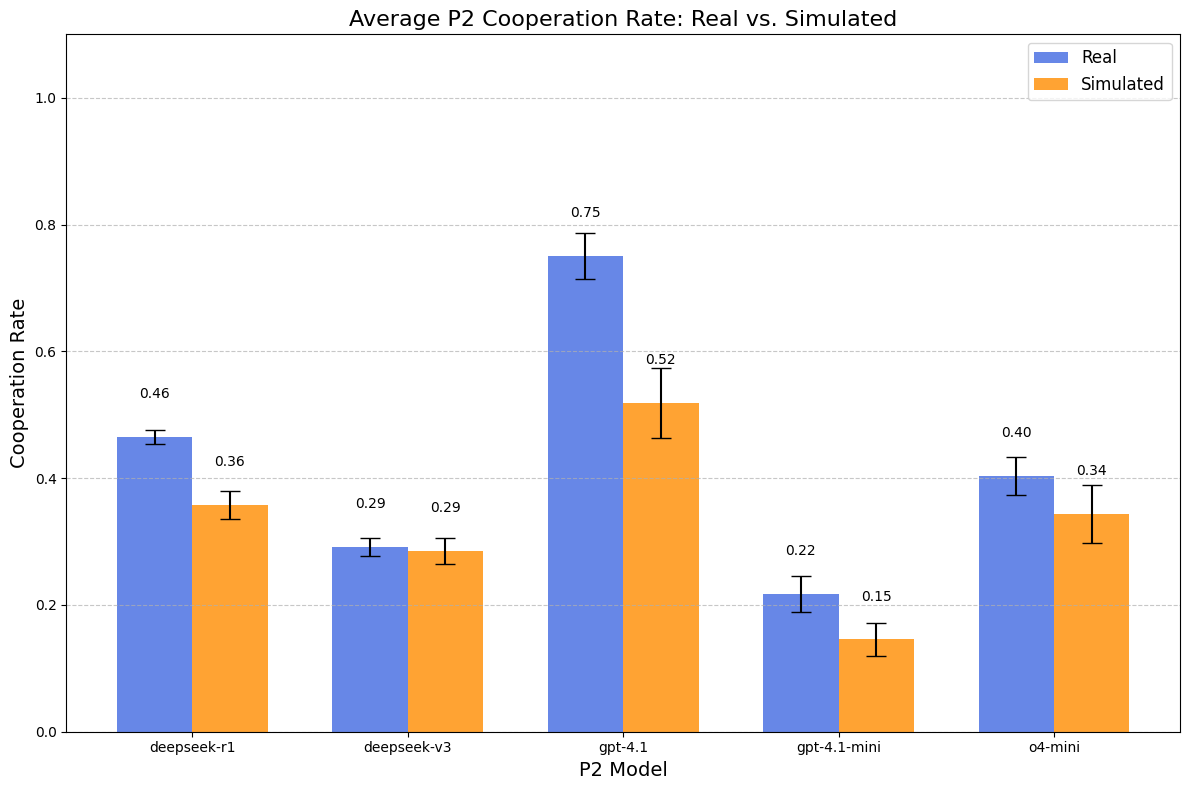

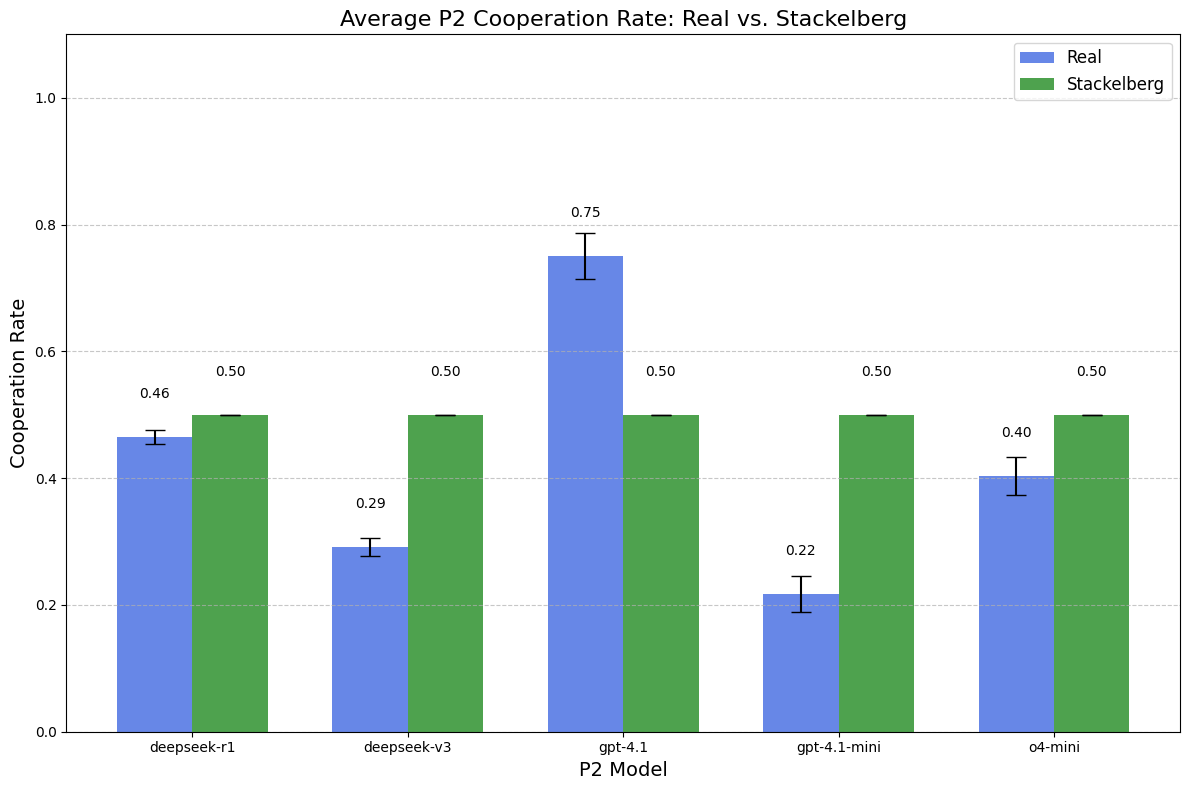

In [138]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

# Assuming df is your DataFrame with the columns specified

# Function to calculate means and confidence intervals for plotting
def get_stats(data, column):
    # Group by model and calculate mean and standard error
    grouped = data.groupby('arg_p2_model')[column].agg(['mean', 'count', 'std'])
    # Calculate 95% confidence interval
    grouped['ci'] = grouped['std'] / np.sqrt(grouped['count']) * 1.96
    return grouped

# PLOT 1: Real vs Simulated Cooperation Rates
def plot_real_vs_simulated(df):
    # Get statistics for real and simulated cooperation
    real_coop = get_stats(df, 'p2_prob_cooperate')
    sim_coop = get_stats(df, 'p2_simulated_prob_cooperate')
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Get the unique models
    models = real_coop.index.tolist()
    x = np.arange(len(models))
    width = 0.35
    
    # Create the bars
    real_bars = ax.bar(x - width/2, real_coop['mean'], width, 
                       yerr=real_coop['ci'], label='Real', 
                       color='royalblue', capsize=7, alpha=0.8)
    sim_bars = ax.bar(x + width/2, sim_coop['mean'], width, 
                      yerr=sim_coop['ci'], label='Simulated', 
                      color='darkorange', capsize=7, alpha=0.8)
    
    # Customize the plot
    ax.set_title('Average P2 Cooperation Rate: Real vs. Simulated', fontsize=16)
    ax.set_xlabel('P2 Model', fontsize=14)
    ax.set_ylabel('Cooperation Rate', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=0, ha='center')
    ax.legend(fontsize=12)
    ax.set_ylim(0, 1.1)  # Setting y-limit to accommodate annotations
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add annotations
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height+0.05),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=10)
    
    add_labels(real_bars)
    add_labels(sim_bars)
    
    plt.tight_layout()
    return fig

# PLOT 2: Real vs Stackelberg Cooperation Rates
def plot_real_vs_stackelberg(df):
    # Get statistics for real and stackelberg cooperation
    real_coop = get_stats(df, 'p2_prob_cooperate')
    # Note: corrected column name to match DataFrame
    stack_coop = get_stats(df, 'stackelberg_p2_prob_cooperate')
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Get the unique models
    models = real_coop.index.tolist()
    x = np.arange(len(models))
    width = 0.35
    
    # Create the bars
    real_bars = ax.bar(x - width/2, real_coop['mean'], width, 
                       yerr=real_coop['ci'], label='Real', 
                       color='royalblue', capsize=7, alpha=0.8)
    stack_bars = ax.bar(x + width/2, stack_coop['mean'], width, 
                        yerr=stack_coop['ci'], label='Stackelberg', 
                        color='forestgreen', capsize=7, alpha=0.8)
    
    # Customize the plot
    ax.set_title('Average P2 Cooperation Rate: Real vs. Stackelberg', fontsize=16)
    ax.set_xlabel('P2 Model', fontsize=14)
    ax.set_ylabel('Cooperation Rate', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=0, ha='center')
    ax.legend(fontsize=12)
    ax.set_ylim(0, 1.1)  # Setting y-limit to accommodate annotations
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add annotations
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height+0.05),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=10)
    
    add_labels(real_bars)
    add_labels(stack_bars)
    
    plt.tight_layout()
    return fig

# Execute both plots
fig1 = plot_real_vs_simulated(df)
plt.savefig('figures/real_vs_simulated_cooperation.png', dpi=300, bbox_inches='tight')

fig2 = plot_real_vs_stackelberg(df)
plt.savefig('figures/real_vs_stackelberg_cooperation.png', dpi=300, bbox_inches='tight')

In [92]:
simulate_count = df['p1_simulate'].sum()
print(simulate_count)

1471


In [68]:
print(df.iloc[0])


timestamp                                                          2025-05-01 21:56:39
round_index                                                                          0
p1_choice                                                                     simulate
p1_move                                                                          trust
p2_choice                                                                    cooperate
p1_payoff                                                                          3.0
p2_payoff                                                                          3.0
p1_gain_from_simulating                                                            0.5
p1_simulation_error                                                                0.0
p2_simulation_prompt                                                               NaN
p1_rationale                         Since simulating the other player has no cost,...
p2_rationale                         Given 

In [76]:
from IPython.display import display, HTML

sub = df[['p1_prob_walk_out',
          'p1_prob_partial_trust',
          'p1_prob_trust',
          'p1_prob_simulate',
          'arg_simulation_type',]]

html = f"""
<div style="max-height:300px; overflow:auto; border:1px solid #ccc; padding:5px;">
  {sub.to_html(index=False)}
</div>
"""
display(HTML(html))


p1_prob_walk_out,p1_prob_partial_trust,p1_prob_trust,p1_prob_simulate,arg_simulation_type
0.000,0.000,0.0,1.0,simulate_and_best_response
0.000,0.000,0.0,1.0,simulate_and_best_response
0.000,0.000,0.0,1.0,simulate_and_best_response
0.000,0.000,0.0,1.0,simulate_and_best_response
0.000,0.000,0.0,1.0,simulate_and_best_response
0.000,0.000,0.0,1.0,simulate_and_best_response
0.000,0.000,0.0,1.0,simulate_and_best_response
0.000,0.000,0.0,1.0,simulate_and_best_response
0.000,0.000,0.0,1.0,simulate_and_best_response
0.000,0.000,0.0,1.0,simulate_and_best_response


In [139]:
def plot_score_distributions(df, outdir):
    """
    1) Spread of each score type on one figure with subplots.
    Numeric scores get histograms; booleans & categories get bar‐counts.
    Also shows p1_payoff_inclusion distribution and a word‐cloud of comments.
    """
    os.makedirs(outdir, exist_ok=True)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    # 1: payoff_error (int)
    axes[0].hist(df['prompt_eval_payoff_error'], 
                 bins=range(int(df['prompt_eval_payoff_error'].max())+2), align='left')
    axes[0].set_title("P2 Payoff Error Distribution")
    axes[0].set_xlabel("P2 Payoff Error")
    axes[0].set_ylabel("Count")

    # 2: rule_error (int)
    axes[1].hist(df['prompt_eval_rule_error'], 
                 bins=range(int(df['prompt_eval_rule_error'].max())+2), align='left')
    axes[1].set_title("Game Rule Error Distribution")
    axes[1].set_xlabel("Game Rule Error")
    axes[1].set_ylabel("Count")

    # 3: extra_score (float)
    axes[2].hist(df['prompt_eval_extra_score'], bins=20)
    axes[2].set_title("Fluency Bonus Distribution")
    axes[2].set_xlabel("Fluency Bonus")
    axes[2].set_ylabel("Count")

    # 4: consistency_score (float)
    axes[3].hist(df['prompt_eval_consistency_score'], bins=20)
    axes[3].set_title("Consistency Score distribution")
    axes[3].set_xlabel("Consistency Score")
    axes[3].set_ylabel("Count")

    # 5: simulation_signal (categorical)
    sim_sig_counts = df['prompt_eval_simulation_signal'].value_counts()
    axes[4].bar(sim_sig_counts.index, sim_sig_counts.values)
    axes[4].set_title("Simulation Signal Distribution")
    axes[4].set_xlabel("Simulation Signal")
    axes[4].set_ylabel("Count")
    axes[4].tick_params(axis='x', rotation=0)

    # 6: simulation_cost (categorical)
    sim_cost_counts = df['prompt_eval_simulation_cost'].value_counts()
    axes[5].bar(sim_cost_counts.index, sim_cost_counts.values)
    axes[5].set_title("Simulation Cost Counts")
    axes[5].set_xlabel("Simulation Cost")
    axes[5].set_ylabel("Count")
    axes[5].tick_params(axis='x', rotation=0)

    # 7: p1_payoff_inclusion (boolean)
    inclusion_counts = df['prompt_eval_p1_payoff_inclusion'].value_counts().reindex([False, True], fill_value=0)
    axes[6].bar(['False', 'True'], inclusion_counts.values, color=['salmon','seagreen'])
    axes[6].set_title("P1 Payoff Inclusion Counts")
    axes[6].set_xlabel("P1 Payoff Inclusion")
    axes[6].set_ylabel("Count")

    # 8: Word cloud of comments
    comments = df['prompt_eval_comments'].dropna().astype(str).values
    text = " ".join(comments)
    if text.strip():
        wc = WordCloud(width=500, height=400, background_color='white').generate(text)
        axes[7].imshow(wc, interpolation='bilinear')
        axes[7].axis('off')
        axes[7].set_title("Comments Word Cloud")
    else:
        axes[7].text(0.5, 0.5, "No comments", ha='center', va='center', fontsize=12)
        axes[7].axis('off')

    plt.suptitle("Score Distributions for P2 Simulation Prompts", fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "score_distributions_extended.png"))
    plt.close()

In [149]:
def plot_consistency_by_p1_model(df: pd.DataFrame, outdir: str) -> None:
    """
    Plot mean consistency_score ±1 SE for each arg_p1_model,
    and annotate each bar with its mean value.
    """
    os.makedirs(outdir, exist_ok=True)
    score_col = 'prompt_eval_consistency_score'

    # aggregate
    stats = (
        df
        .groupby('arg_p1_model')[score_col]
        .agg(['mean','std','count'])
        .reset_index()
    )
    stats['stderr'] = stats['std'] / np.sqrt(stats['count'])

    # plotting
    x = np.arange(len(stats))
    fig, ax = plt.subplots(figsize=(7, 4))

    bars = ax.bar(
        x,
        stats['mean'],
        yerr=stats['stderr'],
        capsize=5,
        color='skyblue',
        edgecolor='black'
    )

    # annotate each bar with its mean value
    for bar, mean, stderr in zip(bars, stats['mean'], stats['stderr']):
        height = bar.get_height() + 0.15
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + stats['stderr'].max() * 0.15,  # offset above the top error bar
            f"{mean:.2f} +/- {stderr:.2f}",
            ha='center',
            va='bottom',
            fontsize=10,
        )

    ax.set_xticks(x)
    ax.set_xticklabels(stats['arg_p1_model'], rotation=0, ha='center')
    ax.set_ylabel('Mean Consistency Score')
    ax.set_title('Consistency Score by P1 Model\n(±1 SE)')
    ax.set_ylim(0, 5)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig(os.path.join(outdir, 'consistency_by_p1_model.png'))
    plt.close()


In [141]:
def plot_payoff_vs_simulation_error(df, outdir):
    os.makedirs(outdir, exist_ok=True)
    plt.figure()
    plt.scatter(df['prompt_eval_payoff_error'], df['p1_simulation_error'], alpha=0.6)
    plt.xlabel("Number of P2 Payoff Errors")
    plt.ylabel("Simulation Error (Avg Probability)")
    plt.title("Payoff Error vs. Simulation Error")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "payoff_vs_p1_simulation_error.png"))
    plt.close()

In [146]:
def plot_signal_vs_p2_coop(df: pd.DataFrame, outdir: str) -> None:
    """
    For each simulation_signal category (ordered: no mention, possible, certain),
    show side-by-side boxplots of:
      - p2_simulated_prob_cooperate
      - p2_prob_cooperate
    Also annotate each category with its sample count.
    """
    os.makedirs(outdir, exist_ok=True)

    # fix category order
    categories = ["no mention", "possible", "certain"]

    # collect data in that order
    sim_data = [
        df.loc[df['prompt_eval_simulation_signal'] == cat, 'p2_simulated_prob_cooperate'].dropna().tolist()
        for cat in categories
    ]
    real_data = [
        df.loc[df['prompt_eval_simulation_signal'] == cat, 'p2_prob_cooperate'].dropna().tolist()
        for cat in categories
    ]

    x = np.arange(len(categories))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))

    # styling props
    boxprops     = dict(linewidth=1.5, edgecolor='black')
    whiskerprops = dict(linewidth=1.2, color='black')
    capprops     = dict(linewidth=1.2, color='black')
    medianprops  = dict(linewidth=2.5, color='darkred')

    # boxplots
    bp_sim = ax.boxplot(
        sim_data,
        positions=x - width/2,
        widths=width,
        patch_artist=True,
        boxprops=boxprops,
        whiskerprops=whiskerprops,
        capprops=capprops,
        medianprops=medianprops,
        manage_ticks=False
    )
    bp_real = ax.boxplot(
        real_data,
        positions=x + width/2,
        widths=width,
        patch_artist=True,
        boxprops=boxprops,
        whiskerprops=whiskerprops,
        capprops=capprops,
        medianprops=medianprops,
        manage_ticks=False
    )

    # fill colors
    for box in bp_sim['boxes']:
        box.set_facecolor('lightblue')
    for box in bp_real['boxes']:
        box.set_facecolor('lightgreen')

    # legend
    legend_patches = [
        Patch(facecolor='lightblue', edgecolor='black', label='Simulated P(cooperate)'),
        Patch(facecolor='lightgreen', edgecolor='black', label='Real P(cooperate)')
    ]
    ax.legend(
        handles=legend_patches,
        loc='upper left',
        bbox_to_anchor=(1.02, 1),
        borderaxespad=0
    )

    # axes labels & title
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=0, ha='right')
    ax.set_xlabel("Simulation Signal")
    ax.set_ylabel("Probability of Cooperate")
    ax.set_title("Simulated vs Real P2 Cooperate by Simulation Signal")
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    # annotate counts
    counts = df['prompt_eval_simulation_signal'] \
                .value_counts() \
                .reindex(categories, fill_value=0)
    ymax = ax.get_ylim()[1]
    for i, cat in enumerate(categories):
        ax.text(
            x[i], 
            ymax * 0.95,
            f"n={counts[cat]}",
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold'
        )

    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "signal_vs_p2_coop_comparison.png"))
    plt.close()

In [147]:
def plot_p1_payoff_inclusion_vs_p2_coop(df, outdir):
    """
    4) p1_payoff_inclusion (bool) vs. p2_simulated_prob_cooperate and p2_prob_cooperate
       Side-by-side boxplots for the two groups (False/True).
    """
    os.makedirs(outdir, exist_ok=True)

    # Group the two series by p1_payoff_inclusion
    sim_group  = df.groupby('prompt_eval_p1_payoff_inclusion')['p2_simulated_prob_cooperate'].apply(list)
    real_group = df.groupby('prompt_eval_p1_payoff_inclusion')['p2_prob_cooperate'].apply(list)

    categories = [False, True]
    labels     = ['False', 'True']
    x          = np.arange(len(categories))
    width      = 0.35

    data_sim   = [sim_group.get(cat, [])  for cat in categories]
    data_real  = [real_group.get(cat, []) for cat in categories]

    fig, ax = plt.subplots(figsize=(8, 5))

    # Common styling props
    boxprops    = dict(linewidth=1.5, edgecolor='black')
    whiskerprops= dict(linewidth=1.2, color='black')
    capprops    = dict(linewidth=1.2, color='black')
    medianprops = dict(linewidth=2.5, color='darkred')

    # Simulated
    bp_sim = ax.boxplot(
        data_sim,
        positions=x - width/2,
        widths=width,
        patch_artist=True,
        boxprops=boxprops,
        whiskerprops=whiskerprops,
        capprops=capprops,
        medianprops=medianprops,
        manage_ticks=False
    )
    # Real
    bp_real = ax.boxplot(
        data_real,
        positions=x + width/2,
        widths=width,
        patch_artist=True,
        boxprops=boxprops,
        whiskerprops=whiskerprops,
        capprops=capprops,
        medianprops=medianprops,
        manage_ticks=False
    )

    # Fill colors
    for box in bp_sim['boxes']:
        box.set_facecolor('lightblue')
    for box in bp_real['boxes']:
        box.set_facecolor('lightgreen')

    # Legend with colored patches
    legend_patches = [
        Patch(facecolor='lightblue', edgecolor='black', label='Simulated P(cooperate)'),
        Patch(facecolor='lightgreen', edgecolor='black', label='Real P(cooperate)')
    ]
    ax.legend(
        handles=legend_patches,
        loc='upper left',
        bbox_to_anchor=(1.02, 1),
        borderaxespad=0
    )

    # annotate counts
    counts = df['prompt_eval_p1_payoff_inclusion'] \
                .value_counts() \
                .reindex(categories, fill_value=0)
    ymax = ax.get_ylim()[1]
    for i, cat in enumerate(categories):
        ax.text(
            x[i], 
            ymax * 0.95,
            f"n={counts[cat]}",
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold'
        )

    # Formatting
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_xlabel("P1 Payoff Included in Prompt")
    ax.set_ylabel("P2 Cooperate Probability")
    ax.set_title("Effect of P1 Payoff Inclusion on P2 Cooperativeness")
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "p1_payoff_inclusion_vs_p2_coop_comparison.png"))
    plt.close()

In [143]:
def plot_rule_error_vs_simulation_error(df, outdir):
    """
    5) rule_error vs. p1_simulation_error
    """
    os.makedirs(outdir, exist_ok=True)
    plt.figure()
    plt.scatter(df['prompt_eval_rule_error'], df['p1_simulation_error'], alpha=0.6)
    plt.xlabel("Number of Game Rule Errors")
    plt.ylabel("Simulation Error (Avg Probability)")
    plt.title("Rule Error vs. Simulation Error")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "rule_error_vs_p1_simulation_error.png"))
    plt.close()

In [158]:
def plot_simulation_vs_real_cooperation_by_type(df, outdir: str) -> None:
    """
    Compare average simulated P2 cooperativeness against the overall real cooperativeness
    for each simulation type, with ±1 SE error bars and y-axis limited to [0,1].

    - Bars show mean p2_simulated_prob_cooperate per simulation type with error bars.
    - A horizontal line shows the overall mean p2_prob_cooperate (real).
    """
    os.makedirs(outdir, exist_ok=True)

    # Aggregate mean, std, count per simulation type
    stats = (
        df
        .groupby('arg_simulation_type')['p2_simulated_prob_cooperate']
        .agg(['mean', 'std', 'count'])
        .reset_index()
    )
    stats['stderr'] = stats['std'] / np.sqrt(stats['count'])

    types    = stats['arg_simulation_type'].tolist()
    means    = stats['mean'].values
    stderrs  = stats['stderr'].values

    # Overall real cooperativeness mean
    real_mean = df['p2_prob_cooperate'].mean()

    x = np.arange(len(types))

    fig, ax = plt.subplots(figsize=(6, 5))
    # Bar plot with error bars
    ax.bar(
        x, means,
        yerr=stderrs,
        capsize=5,
        color='skyblue',
        edgecolor='black',
        label='Simulated P2 P(Cooperate)'
    )

    # Horizontal line for real cooperativeness
    ax.axhline(
        real_mean,
        color='darkred',
        linewidth=2,
        label=f'Real P2 P(Cooperate), mean={real_mean:.2f}'
    )

    # Formatting
    ax.set_xticks(x)
    ax.set_xticklabels(types, rotation=60, ha='right')
    ax.set_xlabel('Simulation Type')
    ax.set_ylabel('Cooperativeness Probability')
    ax.set_title('Simulated vs Real P2 Cooperativeness by Simulation Type')
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.legend(loc='best')

    plt.tight_layout()
    plt.savefig(os.path.join(outdir, 'sim_vs_real_coop_by_sim_type.png'))
    plt.close()

In [168]:
def plot_simulation_error_by_type(df, outdir):
    """
    Plot mean p1_simulation_error ±1 SE for each simulation type.
    """
    os.makedirs(outdir, exist_ok=True)
    score_col = 'p1_simulation_error'
    group_col = 'arg_simulation_type'

    # Aggregate mean, std, count
    stats = (
        df
        .groupby(group_col)[score_col]
        .agg(['mean', 'std', 'count'])
        .reset_index()
    )
    # Compute standard error
    stats['stderr'] = stats['std'] / np.sqrt(stats['count'])

    # Sort by simulation type for consistent ordering (optional)
    stats = stats.sort_values(group_col)

    x = np.arange(len(stats))
    means = stats['mean'].values
    errs = stats['stderr'].values
    labels = stats[group_col].tolist()

    fig, ax = plt.subplots(figsize=(6, 5))
    bars = ax.bar(x, means, yerr=errs, capsize=5, color='salmon', edgecolor='black')
    
    # Annotate bar values
    for xi, m in zip(x, means):
        ax.text(xi, m + 0.05, f"{m:.2f}", ha='center', va='bottom', fontsize=9)

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel('Mean Simulation Error')
    ax.set_title('Simulation Error by Simulation Type (±1 SE)')
    ax.set_ylim(0,0.5)  # start y-axis at zero
    ax.grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.savefig(os.path.join(outdir, 'simulation_error_by_type.png'))
    plt.close()


In [169]:
outdir = "figures/prompt_score_analysis"
os.makedirs(outdir, exist_ok=True)

plot_score_distributions(df, outdir)
plot_payoff_vs_simulation_error(df, outdir)
plot_signal_vs_p2_coop(df, outdir)
plot_p1_payoff_inclusion_vs_p2_coop(df, outdir)
plot_rule_error_vs_simulation_error(df, outdir)
plot_consistency_by_p1_model(df, outdir)
plot_simulation_vs_real_cooperation_by_type(df, outdir)
plot_simulation_error_by_type(df, outdir)

In [82]:
mask = df['prompt_eval_comments'].notna()

for idx, row in df[mask].iterrows():
    print(f"--- Row {idx} ---")
    print("Comments:")
    print(row['prompt_eval_comments'])
    print(f"Scores: payoff={row['prompt_eval_payoff_error']}, p1_payoff={row['prompt_eval_p1_payoff_inclusion']}, signal={row['prompt_eval_simulation_signal']}, cost={row['prompt_eval_simulation_cost']}, rule={row['prompt_eval_rule_error']}, extra={row['prompt_eval_extra_score']}, overall={row['prompt_eval_consistency_score']}")
    print("\nP2 Simulation Prompt:")
    print(row['p2_simulation_prompt'])
    print("\n" + "="*60 + "\n")

--- Row 161 ---
Comments:
The prompt correctly lists P2 payoffs but omits P2's own payoffs and the game rules, including the turn order and allowed actions, which are essential for fidelity to the ground truth.
Scores: payoff=0.0, p1_payoff=False, signal=no mention, cost=missing, rule=0.0, extra=0.8, overall=4.0

P2 Simulation Prompt:
You are playing a restricted trust game as Player 2 (P2). Player 1 (P1) can choose one of three strategies: trust, partial_trust, or walk_out. If P1 chooses walk_out, the game ends immediately and both players get a payoff of 0.

If P1 chooses trust or partial_trust, P2 can respond by either cooperating or defecting.

Your goal is to choose a strategy (cooperate or defect) that maximizes your own expected payoff based on what you think P1 will do.

Here are the payoffs for you as Player 2:

- If P1 plays trust and you cooperate: payoff 3.0  
- If P1 plays trust and you defect: payoff 5.0  
- If P1 plays partial_trust and you cooperate: payoff 2.0  
- If P

In [175]:
def plot_payoff_by_model(df, outdir):
    """
    Bar chart of mean P1 and P2 payoff ±1 SE for each P1 model.
    """
    os.makedirs(outdir, exist_ok=True)

    # Aggregate mean, std, count for both payoffs
    stats = (
        df
        .groupby('arg_p1_model')[['p1_payoff','p2_payoff']]
        .agg(['mean','std','count'])
    )
    # Compute standard errors
    stats[('p1_payoff','stderr')] = stats[('p1_payoff','std')] / np.sqrt(stats[('p1_payoff','count')])
    stats[('p2_payoff','stderr')] = stats[('p2_payoff','std')] / np.sqrt(stats[('p2_payoff','count')])

    # Prepare data
    models = stats.index.tolist()
    x = np.arange(len(models))
    width = 0.35

    p1_means   = stats[('p1_payoff','mean')].values
    p1_errs    = stats[('p1_payoff','stderr')].values
    p2_means   = stats[('p2_payoff','mean')].values
    p2_errs    = stats[('p2_payoff','stderr')].values

    fig, ax = plt.subplots(figsize=(10, 6))
    # P1 bars
    ax.bar(x - width/2, p1_means, width,
           yerr=p1_errs, capsize=5,
           label='P1 Payoff', color='cornflowerblue', edgecolor='black')
    # P2 bars
    ax.bar(x + width/2, p2_means, width,
           yerr=p2_errs, capsize=5,
           label='P2 Payoff', color='lightcoral', edgecolor='black')

    # Annotate means
    for xi, m in zip(x - width/2, p1_means):
        ax.text(xi, m + max(p1_errs) + 0.05, f"{m:.2f}", ha='center', va='bottom', fontsize=9)
    for xi, m in zip(x + width/2, p2_means):
        ax.text(xi, m + max(p2_errs) + 0.05, f"{m:.2f}", ha='center', va='bottom', fontsize=9)

    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=0, ha='center')
    ax.set_ylabel('Average Payoff')
    ax.set_title('Average Payoffs by Model (±1 SE)')
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, 'payoff_by_model.png'))
    plt.close()


def plot_payoff_by_sim_type(df, outdir):
    """
    Bar chart of mean P1 and P2 payoff ±1 SE for each simulation type.
    """
    os.makedirs(outdir, exist_ok=True)

    # Aggregate mean, std, count for both payoffs
    stats = (
        df
        .groupby('arg_simulation_type')[['p1_payoff','p2_payoff']]
        .agg(['mean','std','count'])
    )
    # Compute standard errors
    stats[('p1_payoff','stderr')] = stats[('p1_payoff','std')] / np.sqrt(stats[('p1_payoff','count')])
    stats[('p2_payoff','stderr')] = stats[('p2_payoff','std')] / np.sqrt(stats[('p2_payoff','count')])

    # Prepare data
    sim_types = stats.index.tolist()
    x = np.arange(len(sim_types))
    width = 0.35

    p1_means = stats[('p1_payoff','mean')].values
    p1_errs  = stats[('p1_payoff','stderr')].values
    p2_means = stats[('p2_payoff','mean')].values
    p2_errs  = stats[('p2_payoff','stderr')].values

    fig, ax = plt.subplots(figsize=(10, 6))
    # P1 bars
    ax.bar(x - width/2, p1_means, width,
           yerr=p1_errs, capsize=5,
           label='P1 Payoff', color='cornflowerblue', edgecolor='black')
    # P2 bars
    ax.bar(x + width/2, p2_means, width,
           yerr=p2_errs, capsize=5,
           label='P2 Payoff', color='lightcoral', edgecolor='black')

    # Annotate means
    for xi, m in zip(x - width/2, p1_means):
        ax.text(xi, m + max(p1_errs) + 0.05, f"{m:.2f}", ha='center', va='bottom', fontsize=9)
    for xi, m in zip(x + width/2, p2_means):
        ax.text(xi, m + max(p2_errs)+ 0.05, f"{m:.2f}", ha='center', va='bottom', fontsize=9)

    ax.set_xticks(x)
    ax.set_xticklabels(sim_types, rotation=45, ha='right')
    ax.set_ylabel('Average Payoff')
    ax.set_title('Average Payoffs by Simulation Type (±1 SE)')
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, 'payoff_by_simulation_type.png'))
    plt.close()


In [180]:
def plot_p1_move_distribution(
    df,
    group_col: str,
    outdir: str,
    title: str,
    filename: str
) -> None:
    """
    Stacked bar chart of P1 moves proportions (walk_out, trust, partial_trust)
    by group_col (e.g. 'arg_simulation_type' or 'arg_p1_model'), with total
    sample counts annotated above each bar.
    """
    os.makedirs(outdir, exist_ok=True)

    # Define the move categories and colors
    moves = ['walk_out', 'partial_trust', 'trust']
    colors = {
        'walk_out': '#1f77b4',
        'trust': '#ff7f0e',
        'partial_trust': '#2ca02c',
    }

    # Count occurrences and compute proportions
    grouped_counts = df.groupby(group_col)['p1_move'] \
                       .value_counts() \
                       .unstack(fill_value=0) \
                       .reindex(columns=moves, fill_value=0)
    totals = grouped_counts.sum(axis=1)
    proportions = grouped_counts.div(totals, axis=0)

    # Setup plot
    labels = proportions.index.tolist()
    x = np.arange(len(labels))
    width = 0.6

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot stacked bars
    bottom = np.zeros(len(labels))
    for move in moves:
        vals = proportions[move].values
        ax.bar(
            x,
            vals,
            width,
            bottom=bottom,
            label=move.replace('_', ' ').title(),
            color=colors[move],
            edgecolor='black'
        )
        bottom += vals

    # Annotate total counts above each bar
    for xi, tot in zip(x, totals.values):
        ax.text(
            xi, 1.02,
            f"N = {tot}",
            ha='center', va='bottom',
            fontsize=9
        )

    # Formatting
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylim(0, 1.1)
    ax.set_ylabel("Proportion of P1 Move")
    ax.set_title(title)
    ax.legend(loc='upper right')
    ax.grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.savefig(os.path.join(outdir, filename))
    plt.close()


def plot_p1_move_by_simulation_type(df, outdir):
    plot_p1_move_distribution(
        df,
        group_col='arg_simulation_type',
        outdir=outdir,
        title='P1 Move Distribution by Simulation Type',
        filename='p1_move_by_simulation_type.png'
    )

def plot_p1_move_by_p1_model(df, outdir):
    plot_p1_move_distribution(
        df,
        group_col='arg_p1_model',
        outdir=outdir,
        title='P1 Move Distribution by P1 Model',
        filename='p1_move_by_p1_model.png'
    )

In [183]:
def plot_simulation_frequency_by_model(df, outdir: str) -> None:
    """
    Bar chart showing the fraction (and count) of episodes in which P1 chose to simulate,
    grouped by P1 model (arg_p1_model). Uses the 'simulate' column (0/1).
    """
    os.makedirs(outdir, exist_ok=True)

    # Group by model
    stats = (
        df
        .groupby('arg_p1_model')['p1_simulate']
        .agg(total=('count'), num_sim=('sum'))
        .reset_index()
    )
    stats['freq'] = stats['num_sim'] / stats['total']

    # Plot setup
    models = stats['arg_p1_model'].tolist()
    freqs = stats['freq'].values
    counts = stats['total'].values

    x = np.arange(len(models))
    width = 0.6

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(x, freqs, width, color='skyblue', edgecolor='black')

    # Annotate counts and percentages
    for xi, bar, tot, num in zip(x, bars, counts, stats['num_sim'].values):
        height = bar.get_height()
        ax.text(
            xi, height + 0.02,
            f"{num}/{tot}\n{height:.0%}",
            ha='center', va='bottom', fontsize=9
        )

    # Formatting
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("Simulation Frequency")
    ax.set_title("P1 Simulation Frequency by Model")
    ax.grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "simulation_frequency_by_model.png"))
    plt.close()

In [184]:
outdir = "figures"
os.makedirs(outdir, exist_ok=True)
plot_payoff_by_model(df, outdir)
plot_payoff_by_sim_type(df, outdir)
plot_p1_move_by_simulation_type(df, outdir)
plot_p1_move_by_p1_model(df, outdir)
plot_simulation_frequency_by_model(df, outdir)